In [11]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime
import seaborn as sns

import MP_functions as dfutil

%matplotlib inline

# Importing & Loading Data

Make sure to unzip the pickles.zip into the root folder for the project.

In [132]:
# from load_pickles import df as pickle
df = dfutil.open_dataframe_pickle('MTA_DATA_SPRING_2014_to_2016_FULL.pickle')
dtp = dfutil.open_dataframe_pickle('daily_throughput.pickle')
htp = dfutil.open_dataframe_pickle('hourly_throughput.pickle')

# Functions

In [39]:
def cleanData(frame):
    # Strip whitespace from column names
    frame.columns = [s.strip() for s in frame.columns.values]

    # Create datetime column with datetime datatype
    frame['Datetime'] = pd.to_datetime(frame.DATE + ' ' + frame.TIME,
                                        format = '%m/%d/%Y %H:%M:%S')
    frame['Day_of_week'] = frame['Datetime'].apply(lambda row: row.strftime("%A"))
    
    # Chain methods together to further clean data:
        # drop old date and time columns
        # rename columns
    
    dict_col_rename = {'C/A' : 'C_A', 'UNIT' : 'Unit', 'STATION' : 'Station', 'LINENAME' : 'Linename',
                      'DIVISION' : 'Division', 'DESC' : 'Desc', 'ENTRIES' : 'Entries', 'EXITS' : 'Exits',
                      'DATE' : 'Date'}    

    frame2 = frame.rename(columns = dict_col_rename)
    
    # Check uniqueness of rows/indexes by getting counts.
    (frame2
     .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])
     .count() #.Entries.count()
     .reset_index()
     .sort_values('Entries', ascending = False)
    )
    
    # Drop duplicates.
    return frame2.drop_duplicates(subset=['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])
    
    

In [40]:
def calcDailyThroughput(frame):
    
    # group daily entries and daily exits
    daily_entries = (frame
                      .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                      .Entries
                      .first()
                      .reset_index()
                    )

    daily_exits = (frame
                    .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                    .Exits
                    .first()
                    .reset_index()
                   )
    
    # Calculate the differences by day
    daily_entries[["Prev_date", "Prev_entries"]] = (daily_entries
                                                     .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Entries"]
                                                     .transform(lambda grp: grp.shift(1)))

    daily_exits[["Prev_date", "Prev_exits"]]   = (daily_exits
                                                   .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Exits"]
                                                   .transform(lambda grp: grp.shift(1)))

    # Drop all the null values generated above
    daily_entries.dropna(subset=["Prev_date"], axis=0, inplace=True)
    daily_exits.dropna(subset=["Prev_date"], axis=0, inplace=True)


    daily_entries["Daily_Entries"] = daily_entries.apply(get_daily_counts, axis=1, args=(1000000, ['Entries', 'Prev_entries']))
    daily_exits["Daily_Exits"] = daily_exits.apply(get_daily_counts, axis=1, args=(1000000, ['Exits', 'Prev_exits']))
    
    daily = pd.merge(daily_entries, daily_exits, on=['C_A','Unit','SCP', 'Station', 'Date', 'Prev_date'])
    daily['Total_throughput'] = daily['Daily_Entries'] + daily['Daily_Exits']
    
    return (daily
             .groupby(['Station', 'Date'])
             .sum()
            #  .sort_values(by=['Total_throughput'], ascending=False)
             .loc[:,['Daily_Entries', 'Daily_Exits', 'Total_throughput']]
            #  .frame()
            )

In [41]:
def calcDailyThroughput(frame):
    
    # group daily entries and daily exits
    daily_entries = (frame
                      .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                      .Entries
                      .first()
                      .reset_index()
                    )

    daily_exits = (frame
                    .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                    .Exits
                    .first()
                    .reset_index()
                   )
    
    # Calculate the differences by day
    daily_entries[["Prev_date", "Prev_entries"]] = (daily_entries
                                                     .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Entries"]
                                                     .transform(lambda grp: grp.shift(1)))

    daily_exits[["Prev_date", "Prev_exits"]]   = (daily_exits
                                                   .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Exits"]
                                                   .transform(lambda grp: grp.shift(1)))

    # Drop all the null values generated above
    daily_entries.dropna(subset=["Prev_date"], axis=0, inplace=True)
    daily_exits.dropna(subset=["Prev_date"], axis=0, inplace=True)


    daily_entries["Daily_Entries"] = daily_entries.apply(get_daily_counts, axis=1, args=(1000000, ['Entries', 'Prev_entries']))
    daily_exits["Daily_Exits"] = daily_exits.apply(get_daily_counts, axis=1, args=(1000000, ['Exits', 'Prev_exits']))
    
    daily = pd.merge(daily_entries, daily_exits, on=['C_A','Unit','SCP', 'Station', 'Date', 'Prev_date'])
    daily['Total_throughput'] = daily['Daily_Entries'] + daily['Daily_Exits']
    
    return (daily
             .groupby(['Station', 'Date'])
             .sum()
            #  .sort_values(by=['Total_throughput'], ascending=False)
             .loc[:,['Daily_Entries', 'Daily_Exits', 'Total_throughput']]
            #  .frame()
            )

In [81]:
def calcDailyEntries(frame):
    
    # group daily entries and daily exits
    daily_entries = (frame
                      .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
                      .Entries
                      .first()
                      .reset_index()
                    )
    
    # Calculate the differences by day
    daily_entries[["Prev_date", "Prev_entries"]] = (daily_entries
                                                     .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Entries"]
                                                     .transform(lambda grp: grp.shift(1)))

    # Drop all the null values generated above
    daily_entries.dropna(subset=["Prev_date"], axis=0, inplace=True)

    daily_entries["Daily_Entries"] = daily_entries.apply(get_daily_counts, axis=1, args=(1000000, ['Entries', 'Prev_entries']))
    
#     daily = pd.merge(daily_entries, on=['C_A','Unit','SCP', 'Station', 'Date', 'Prev_date'])
#     daily['Total_throughput'] = daily['Daily_Entries'] + daily['Daily_Exits']
    
    return (daily_entries
#              .groupby(['Station', 'Date'])
#              .mean()
            #  .sort_values(by=['Total_throughput'], ascending=False)
#              .loc[:,['Daily_Entries']]
            #  .frame()
            )

In [73]:
def get_daily_counts(row, max_diff, cols):
    """
    cols - a list of columns to compute the difference from with format [x, y] = x-y
    """
    #col0 = current
    # col11 = prev
    CURRENT = cols[0]
    PREV = cols[1]
    
    diff = row[CURRENT] - row[PREV]
    if diff < 0:
        # May be counter is reversed?
        diff = -diff
    if diff > max_diff:
#         print(row[CURRENT], row[PREV])
        diff = min(row[CURRENT], row[PREV])
    if diff > max_diff:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return diff

In [ ]:
def calcHourThroughput(frame):
    shift = frame.copy()

    shift[['Datetime_Prev', 'Entries_Prev', 'Exits_Prev']] = (shift
                .groupby(['C_A', 'Unit', 'SCP', 'Station'])['Datetime', 'Entries', 'Exits']
                .transform(lambda grp: grp.shift(1)))
    
    shift['Entries'] = shift['Entries'] - shift['Entries_Prev']
    shift['Exits'] = shift['Exits'] - shift['Exits_Prev']
    shift = shift.dropna(how = 'any')
    
    shift['Throughput'] = shift['Entries'] + shift['Exits']
    
    return shift.loc[:,['Station','Datetime','Throughput']]

In [ ]:
# Make note to save and open pickles here:
# dfutil.save_dataframe_as_pickle(df,'MTA_DATA_SPRING_2014_to_2016_FULL.pickle')
# df_pickle = dfutil.open_dataframe_pickle('MTA_DATA_SPRING_2014_to_2016_FULL.pickle') # returns a df

# Daily Throughput

In [105]:
mask = df['Date'].str.contains('/2016')
df_2016 = df[mask]

In [108]:
daily_2016 = calcDailyEntries(df_2016)

In [110]:
daily_2016['Daily_Entries'].describe()

count   540040.00
mean      1199.13
std       5319.69
min          0.00
25%        282.00
50%        867.00
75%       1698.00
max     979909.00
Name: Daily_Entries, dtype: float64

### Outliers

In [129]:
o200k_mask = daily_2016['Daily_Entries'] < 700000
less250k = daily_2016[o200k_mask].copy(deep=True)

In [126]:
less250k

,C_A,Unit,SCP,Station,Date,Entries,Prev_date,Prev_entries,Daily_Entries
1,A002,R051,02-00-00,59 ST,02/28/2016,5563262,02/27/2016,5562172.00,1090.00
2,A002,R051,02-00-00,59 ST,02/29/2016,5564033,02/28/2016,5563262.00,771.00
3,A002,R051,02-00-00,59 ST,03/01/2016,5565799,02/29/2016,5564033.00,1766.00
4,A002,R051,02-00-00,59 ST,03/02/2016,5567572,03/01/2016,5565799.00,1773.00
5,A002,R051,02-00-00,59 ST,03/03/2016,5569303,03/02/2016,5567572.00,1731.00
6,A002,R051,02-00-00,59 ST,03/04/2016,5571113,03/03/2016,5569303.00,1810.00
7,A002,R051,02-00-00,59 ST,03/05/2016,5572932,03/04/2016,5571113.00,1819.00
8,A002,R051,02-00-00,59 ST,03/06/2016,5574011,03/05/2016,5572932.00,1079.00
9,A002,R051,02-00-00,59 ST,03/07/2016,5574814,03/06/2016,5574011.00,803.00
10,A002,R051,02-00-00,59 ST,03/08/2016,5576527,03/07/2016,5574814.00,1713.00


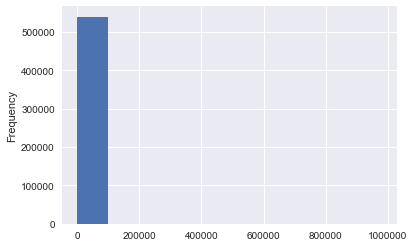

In [117]:
daily_2016['Daily_Entries'].plot.hist();

In [130]:
# less250k = dtp.reset_index()
less250k['Day_of_week'] = pd.to_datetime(less250k['Date'], format = '%m/%d/%Y').apply(lambda row: row.strftime("%A"))
less250k_mean = less250k.groupby(['Day_of_week','Station'])['Daily_Entries'].mean().reset_index()
pivot = less250k_mean.pivot(index='Station', columns='Day_of_week', values = 'Daily_Entries')
# dtp[['Daily_Entries', 'Station']].sort_values('Daily_Entries',ascending=False)


monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

dtp_weekly = pd.DataFrame({'Monday': monday,
                           'Tuesday': tuesday,
                           'Wednesday': wednesday,
                           'Thursday': thursday,
                           'Friday': friday,
                           'Saturday': saturday,
                           'Sunday': sunday})

dtp_weekly.head(5)

# use this if you need to make a pickle
# dfutil.save_dataframe_as_pickle(dtp_weekly,'dtp_weekly.pickle')

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,YORK ST,METROPOLITAN AVE,JOURNAL SQUARE,BEDFOROAD AVE,GATES AVE,PATH WTC 2,MORISN AVE/SNDVW
1,SUTTER AVE-RUTLD,YORK ST,170 ST,THIRTY ST,GUN HILL ROAD,NASSAU ST,3 AVE 138 ST
2,MYRTLE AVE,BEDFOROAD AVE,PAVEONIA/NEWPORT,YORK ST,YORK ST,UTICA AVE,181 ST
3,14 ST-UNION SQ,MYRTLE AVE,SUTTER AVE-RUTLD,14 ST-UNION SQ,SUTTER AVE-RUTLD,PAVEONIA/NEWPORT,GROVE STREET
4,116 ST-COLUMBIA,MONTROSE AVE,PATH WTC,MYRTLE AVE,MYRTLE AVE,YORK ST,85 ST-FOREST PARK


## Looking at the mean of entries

In [77]:
dtp.head()

Daily_Entries  Daily_Exits  Total_throughput
Station Date                                                    
1 AVE   02/28/2015     2149122.00    341314.00        2490436.00
        02/28/2016     2153712.00    342328.00        2496040.00
        02/29/2016       14018.00     15107.00          29125.00
        03/01/2015     2151936.00    342214.00        2494150.00
        03/01/2016     2156668.00    343143.00        2499811.00

In [78]:
dtp = dtp.reset_index()
dtp['Day_of_week'] = pd.to_datetime(dtp['Date'], format = '%m/%d/%Y').apply(lambda row: row.strftime("%A"))
dtp_mean = dtp.groupby(['Day_of_week','Station'])['Daily_Entries'].mean().reset_index()
pivot = dtp_mean.pivot(index='Station', columns='Day_of_week', values = 'Daily_Entries')
# dtp[['Daily_Entries', 'Station']].sort_values('Daily_Entries',ascending=False)


monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

dtp_weekly = pd.DataFrame({'Monday': monday,
                           'Tuesday': tuesday,
                           'Wednesday': wednesday,
                           'Thursday': thursday,
                           'Friday': friday,
                           'Saturday': saturday,
                           'Sunday': sunday})

dtp_weekly.head(5)

# use this if you need to make a pickle
# dfutil.save_dataframe_as_pickle(dtp_weekly,'dtp_weekly.pickle')

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA,34 ST-PENN STA
1,FULTON ST,FULTON ST,FULTON ST,FULTON ST,FULTON ST,FULTON ST,FULTON ST
2,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST,CHAMBERS ST
3,86 ST,86 ST,86 ST,86 ST,86 ST,86 ST,86 ST
4,125 ST,125 ST,125 ST,125 ST,CANAL ST,125 ST,125 ST


In [28]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [29]:
pivot.describe()

Day_of_week,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
count,482.00,482.00,482.00,482.00,482.00,482.00,482.00
mean,1977711.91,1974320.14,2037390.65,2031683.84,2035321.89,2038255.29,2038710.93
std,3394740.05,3401518.74,3504504.94,3503057.65,3495302.91,3502216.72,3502971.78
min,736.35,366.18,714.38,478.82,774.35,714.88,721.82
25%,14325.40,6019.41,14262.58,7912.57,14818.00,13676.63,14831.29
50%,878459.39,879843.93,892638.23,891524.78,909133.43,906872.93,908389.62
75%,2434867.57,2429649.42,2506775.21,2493596.83,2507922.60,2505506.51,2507856.30
max,35954423.18,35884285.68,37065236.73,36992277.41,36983678.76,36987703.12,36995890.29


In [6]:
dtp = dtp.reset_index()
dtp['Day_of_week'] = pd.to_datetime(dtp['Date'], format = '%m/%d/%Y').apply(lambda row: row.strftime("%A"))

dtp_sum = dtp.groupby(['Day_of_week','Station'])['Total_throughput'].sum().reset_index()
pivot = dtp_sum.pivot(index='Station', columns='Day_of_week', values = 'Total_throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

In [ ]:
# dtp['Day_of_week'] = #(pd.to_datetime(dtp.reset_index()['Date'], format = '%m/%d/%Y'))

In [ ]:
%matplotlib inline
dtp_sum.hist()

In [ ]:
dtp_mean = dtp.groupby(['Day_of_week','Station'])['Total_throughput'].mean().reset_index()
pivot = dtp_mean.pivot(index='Station', columns='Day_of_week', values = 'Total_throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

In [ ]:
pivot.describe()

In [ ]:
df.head(20)

In [ ]:
pivot['Monday'].sort_values(ascending=False).head()

In [ ]:
pivot.index.values
pivot.loc['42 ST-GROAD CNTRL', :]

In [ ]:
pivot['Friday'].sort_values(ascending=False).head(10)

In [ ]:
pivot['Monday'].sort_values(ascending=False).head(10)

In [ ]:
# dfutil.save_dataframe_as_pickle(df,'ranked_stations_by_day.pickle')

# TODO

Day of the week - 7 days 
- index'd by rank
- names of stations 
- each column is a time of the day

map of morning, afternoon, evening
     for each day of week


# Hourly Throughput

In [ ]:
# htp_mean = htp.groupby(['Station', 'Datetime']).mean().reset_index()

In [ ]:
dtp['Day_of_week'] = dtp['Datetime'].apply(lambda row: row.strftime("%A"))

In [ ]:
htp['Day_of_week'] = htp['Datetime'].apply(lambda row: row.strftime("%A"))

In [ ]:
htp['Hour'] = htp['Datetime'].apply(lambda row: row.strftime("%-I%p"))

In [ ]:
eight_am_mask = (htp['Hour'] == '7AM') | (htp['Hour'] == '8AM') | (htp['Hour'] == '9AM') | (htp['Hour'] == '10AM')
four_pm_mask = (htp['Hour'] == '4PM') | (htp['Hour'] == '5PM') | (htp['Hour'] == '6PM') | (htp['Hour'] == '7PM') | (htp['Hour'] == '8PM')
twelve_pm_mask = (htp['Hour'] == '11AM') | (htp['Hour'] == '12PM') | (htp['Hour'] == '1PM') | (htp['Hour'] == '2PM') | (htp['Hour']) == '3PM'

In [ ]:
htp_8am = htp.loc[eight_am_mask,:].groupby(['Station','Day_of_week','Hour']).mean()
htp_12pm = htp.loc[twelve_pm_mask,:].groupby(['Station','Day_of_week','Hour']).mean()
htp_4pm = htp.loc[four_pm_mask,:].groupby(['Station','Day_of_week','Hour']).mean()

In [ ]:
htp_8am_station_mean = htp_8am.reset_index().groupby(['Station','Day_of_week']).mean().reset_index()
pivot = (htp_8am_station_mean
         .pivot(index='Station', columns='Day_of_week', values = 'Throughput')
         .apply(lambda row: abs(row)))


monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

e8_am_df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

# dfutil.save_dataframe_as_pickle(e8_am_df,'8am_hourly_tp.pickle')

e8_am_df.head(10)

In [ ]:
mask = (pivot > 20000)
pivot[mask].dropna(how='all')

In [ ]:
_149st = htp['Station'] == '149 ST-3 AVE'
_g1000 = htp[_149st]['Throughput'] > 1000

# _g1000
_g1000
# htp[_g1000]

In [ ]:
htp[_g1000]

In [ ]:
htp_12pm_station_mean = htp_12pm.reset_index().groupby(['Station','Day_of_week']).mean().reset_index()
pivot = htp_12pm_station_mean.pivot(index='Station', columns='Day_of_week', values = 'Throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

t12_pm_df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

# dfutil.save_dataframe_as_pickle(t12_pm_df,'12pm_hourly_tp.pickle')

t12_pm_df.head(10)

In [ ]:
htp_4pm_station_mean = htp_4pm.reset_index().groupby(['Station','Day_of_week']).mean().reset_index()
pivot = htp_4pm_station_mean.pivot(index='Station', columns='Day_of_week', values = 'Throughput')

monday = pivot['Monday'].sort_values(ascending=False).index.values
tuesday = pivot['Tuesday'].sort_values(ascending=False).index.values
wednesday = pivot['Wednesday'].sort_values(ascending=False).index.values
thursday = pivot['Thursday'].sort_values(ascending=False).index.values
friday = pivot['Friday'].sort_values(ascending=False).index.values
saturday = pivot['Saturday'].sort_values(ascending=False).index.values
sunday = pivot['Sunday'].sort_values(ascending=False).index.values

f4_pm_df = pd.DataFrame({'Monday': monday,
                  'Tuesday': tuesday,
                  'Wednesday': wednesday,
                  'Thursday': thursday,
                  'Friday': friday,
                  'Saturday': saturday,
                  'Sunday': sunday})

# dfutil.save_dataframe_as_pickle(f4_pm_df,'4pm_hourly_tp.pickle')

f4_pm_df.head(10)

In [ ]:
htp_8am.groupby(['Day_of_week']).max()

# Data Exploration 
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

## Data Cleaning

In [ ]:
# The column names contain unneeded whitespace.
df1.columns.values

In [ ]:
# The dataframe also lacks a timeseries.
df1.dtypes

In [ ]:
# Strip whitespace from column names
df1.columns = [s.strip() for s in df1.columns.values]

# Create datetime column with datetime datatype
df1['Datetime'] = pd.to_datetime(df1.DATE + ' ' + df1.TIME,
                                 format = '%m/%d/%Y %H:%M:%S')

df1.iloc[:5]

In [ ]:
# Chain methods together to further clean data:
    # drop old date and time columns
    # rename columns
    
dict_col_rename = {'C/A' : 'C_A', 'UNIT' : 'Unit', 'STATION' : 'Station', 'LINENAME' : 'Linename',
                  'DIVISION' : 'Division', 'DESC' : 'Desc', 'ENTRIES' : 'Entries', 'EXITS' : 'Exits',
                  'DATE' : 'Date'}    

df2 = (df1
       #.drop('DATE', axis = 1)
       .drop('TIME', axis = 1)
       .rename(columns = dict_col_rename)
      )

df2.iloc[:5]

# Removing Erroneous Observations

In [ ]:
# Check uniqueness of rows/indexes by getting counts.
(df2
 .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])
 .count() #.Entries.count()
 .reset_index()
 .sort_values('Entries', ascending = False)
 .iloc[:5]
)

In [ ]:
# On 3/25, we don't seem to have two entries for same time, but let's take a look anyway.

mask = ((df2["C_A"] == "A002") & 
(df2["Unit"] == "R051") & 
(df2["SCP"] == "02-00-00") & 
(df2["Station"] == "59 ST") &
(df2["Datetime"].dt.date == datetime.datetime(2017, 3, 25).date()))
df2[mask].head()

In [ ]:
df2.Desc.value_counts()

In [ ]:
# Questions for the future, if there is time:
    # Are there other values of DESC?
    # Are there other fields to check for odd values?

# Drop duplicates.
df_no_dupe = df2.drop_duplicates(subset=['C_A', 'Unit', 'SCP', 'Station', 'Datetime'])

# Check uniqueness again after data cleaning to confirm cleanness.

In [ ]:
df_no_dupe.head()

# Calculating the Entries and Exits per Day

In [ ]:
df_daily_entries = (df_no_dupe
            .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
            .Entries
            .first()
            .reset_index()
           )

df_daily_exits = (df_no_dupe
            .groupby(['C_A', 'Unit', 'SCP', 'Station', 'Date'])
            .Exits
            .first()
            .reset_index()
           )


In [ ]:
# Calculate the differences by day
df_daily_entries[["Prev_date", "Prev_entries"]] = (df_daily_entries
                                                       .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Entries"]
                                                       .transform(lambda grp: grp.shift(1)))

df_daily_exits[["Prev_date", "Prev_exits"]]   = (df_daily_exits
                                                       .groupby(["C_A", "Unit", "SCP", "Station"])["Date", "Exits"]
                                                       .transform(lambda grp: grp.shift(1)))

# Drop all the null values generated above
df_daily_entries.dropna(subset=["Prev_date"], axis=0, inplace=True)
df_daily_exits.dropna(subset=["Prev_date"], axis=0, inplace=True)

In [ ]:
df_daily_entries.head()

In [ ]:
# Check for any counters that have been reversed
df_daily_entries[df_daily_entries["Entries"] < df_daily_entries["Prev_entries"]].head()

# WTC: Is this something that can be solved by sorting before applying the transform above?

In [ ]:
##### HAVE NOT EDITED YET

# Pick a value from one of the counters reversed above & check for it 
# What's the deal with counter being in reverse
# mask = ((turnstiles_df["C/A"] == "A011") & 
# (turnstiles_df["UNIT"] == "R080") & 
# (turnstiles_df["SCP"] == "01-00-00") & 
# (turnstiles_df["STATION"] == "57 ST-7 AV") &
# (turnstiles_df["DATE_TIME"].dt.date == datetime.datetime(2016, 8, 27).date()))
# turnstiles_df[mask].head()

In [ ]:
# Let's see how many stations have this problem

(df_daily_entries[df_daily_entries["Entries"] < df_daily_entries["Prev_entries"]]
    .groupby(["C_A", "Unit", "SCP", "Station"])
    .size())

In [ ]:
# def get_daily_counts(row, max_counter, cols):
#     counter = row[cols[0]] - row[cols[1]]
#     if counter < 0:
#         # May be counter is reversed?
#         counter = -counter
#     if counter > max_counter:
#         print(row[cols[0]], row[cols[1]])
#         counter = min(row[cols[0]], row[cols[1]])
#     if counter > max_counter:
#         # Check it again to make sure we are not giving a counter that's too big
#         return 0
#     return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
df_daily_entries["Daily_Entries"] = df_daily_entries.apply(get_daily_counts, axis=1, args=(1000000, ['Entries', 'Prev_entries']))
df_daily_exits["Daily_Exits"] = df_daily_exits.apply(get_daily_counts, axis=1, args=(1000000, ['Exits', 'Prev_exits']))

In [ ]:
df_daily_entries.head()

In [ ]:
df_daily_exits.head()

In [ ]:
df_daily = pd.merge(df_daily_entries, df_daily_exits, on=['C_A','Unit','SCP', 'Station', 'Date', 'Prev_date'])
df_daily['Total_throughput'] = df_daily['Daily_Entries'] + df_daily['Daily_Exits']
df_daily.head()

In [ ]:
(df_daily
 .groupby(['Station', 'Date'])
 .sum()
#  .sort_values(by=['Total_throughput'], ascending=False)
 .loc[:,['Daily_Entries', 'Daily_Exits', 'Total_throughput']]
#  .frame()
)

# Calculating the Entries and Exits per Hour


In [ ]:
# Use concat (as a join) to fix ("de-cumulate") the columns Entries and Exits

df_shift = (df_no_dupe
            .copy()
            .drop('Linename', axis = 1)
            .drop('Division', axis = 1)
           )

df_shift[['Datetime_Prev', 'Entries_Prev', 'Exits_Prev']] = (df_shift
            .groupby(['C_A', 'Unit', 'SCP', 'Station'])['Datetime', 'Entries', 'Exits']
            .transform(lambda grp: grp.shift(1)))

df_shift.head()


# Legacy

# df_shift.columns
# df_shift['Datetime_Prev', 'Entries_Prev', 'Exits_Prev'] = (
#     df_no_dupe#[['C_A', 'Unit', 'SCP', 'Station', 'Datetime', 'Entries', 'Exits']]
#             .groupby(['C_A', 'Unit', 'SCP', 'Station'])['Datetime', 'Entries', 'Exits']
#             #.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
#             .transform(lambda grp: grp.shift(1))
#             #.shift(periods = 1)
#             #.rename(columns = {'Entries' : 'Entries_Shift', 'Exits' : 'Exits_Shift', 
#             #                   'Datetime' : 'Prev_datetime'})
#            )

In [ ]:
df_shift['Entries'] = df_shift['Entries'] - df_shift['Entries_Prev']
df_shift['Exits'] = df_shift['Exits'] - df_shift['Exits_Prev']
df_shift = df_shift.dropna(how = 'any')

df_shift.head()

In [ ]:
# Challenge 3 - Total Daily Entries
#df3or4['Datetime'].dt.date == datetime.datetime(YYYY, MM, DD).date()

In [ ]:
# def get_daily_counts(row, max_counter):
#     counter = abs(row["ENTRIES"] - row["PREV_ENTRIES"])
    
#     if counter > max_counter:
#         print(row["ENTRIES"], row["PREV_ENTRIES"])
#         return 0
#     return counter

# # If counter is > 1Million, then the counter might have been reset.  
# # Just set it to zero as different counters have different cycle limits
# _ = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)